<a href="https://colab.research.google.com/github/PETEROA/ML-Optimization-Daily/blob/main/Knowledge_Dis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook provides a comprehensive exploration of knowledge distillation, the technique of training a smaller "student" network to mimic a larger "teacher" network. Unlike pruning and quantization which compress a trained model, distillation transfers learned knowledge into a fundamentally different (typically smaller) architecture. We begin with Hinton's seminal insight: softened probability distributions contain richer information than hard labels, encoding the teacher's learned similarity structure between classes. We then implement three families of distillation methods from scratch: response-based (soft targets), feature-based (intermediate representations), and relation-based (structural relationships). Our experimental framework systematically compares these approaches on MNIST, measuring how effectively different knowledge types transfer from large to small networks. The analysis connects distillation theory to broader research themes including model compression (distillation + quantization + pruning pipelines), neural architecture search (distillation for architecture evaluation), and the geometry of learned representations, directly relevant to geometry-aware distillation approaches.



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, List, Dict, Tuple, Callable
from dataclasses import dataclass
from copy import deepcopy
from collections import OrderedDict
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

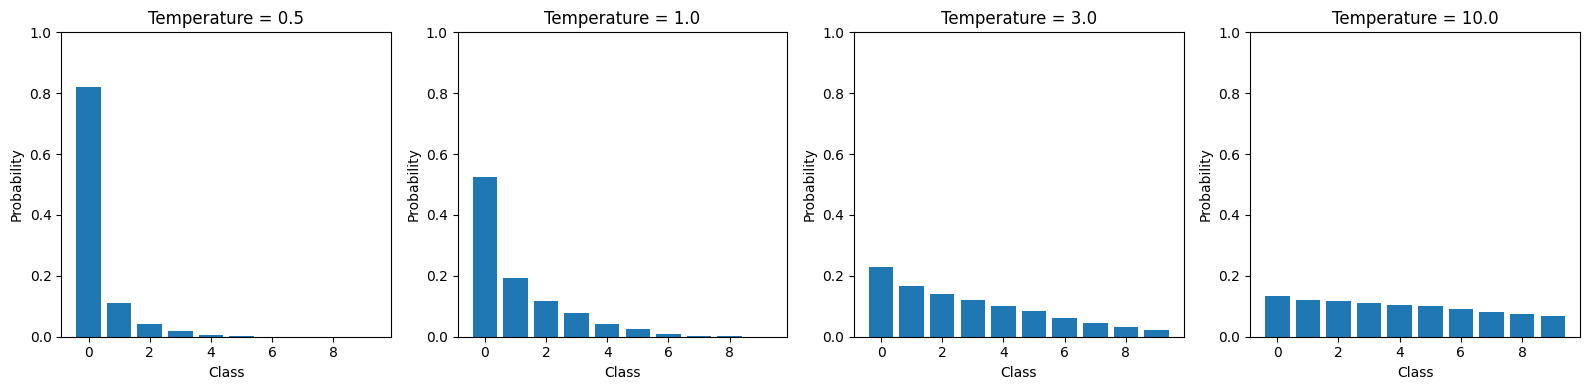

In [2]:
def softmax_with_temperature(logits: torch.Tensor, temperature: float = 1.0) -> torch.Tensor:

    return F.softmax(logits / temperature, dim=-1)


def visualize_temperature_effect():
    """Show how temperature affects softmax distribution."""
    logits = torch.tensor([2.0, 1.0, 0.5, 0.1, -0.5, -1.0, -2.0, -3.0, -4.0, -5.0])

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    temperatures = [0.5, 1.0, 3.0, 10.0]

    for ax, T in zip(axes, temperatures):
        probs = softmax_with_temperature(logits, T)
        ax.bar(range(10), probs.numpy())
        ax.set_xlabel('Class')
        ax.set_ylabel('Probability')
        ax.set_title(f'Temperature = {T}')
        ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.savefig('temperature_effect.png', dpi=150, bbox_inches='tight')
    plt.show()

visualize_temperature_effect()

In [3]:
class DistillationLoss(nn.Module):


    def __init__(
        self,
        temperature: float = 4.0,
        alpha: float = 0.5
    ):
        """
        Args:
            temperature: Softening temperature for soft targets
            alpha: Weight for hard loss (1 - alpha for soft loss)
        """
        super().__init__()
        self.temperature = temperature
        self.alpha = alpha

    def forward(
        self,
        student_logits: torch.Tensor,
        teacher_logits: torch.Tensor,
        labels: torch.Tensor
    ) -> Tuple[torch.Tensor, Dict[str, float]]:


        # Hard loss: standard cross-entropy with true labels
        hard_loss = F.cross_entropy(student_logits, labels)

        # Soft loss: KL divergence with teacher's soft targets
        # KL(P || Q) = Σ P * log(P/Q) = Σ P * log(P) - Σ P * log(Q)
        # F.kl_div expects log-probabilities as input
        student_soft = F.log_softmax(student_logits / self.temperature, dim=-1)
        teacher_soft = F.softmax(teacher_logits / self.temperature, dim=-1)

        # KL divergence (reduction='batchmean' gives proper scaling)
        soft_loss = F.kl_div(student_soft, teacher_soft, reduction='batchmean')

        # T² scaling compensates for gradient magnitude reduction
        soft_loss = soft_loss * (self.temperature ** 2)

        # Combined loss
        total_loss = self.alpha * hard_loss + (1 - self.alpha) * soft_loss

        return total_loss, {
            'hard_loss': hard_loss.item(),
            'soft_loss': soft_loss.item(),
            'total_loss': total_loss.item()
        }

In [4]:
class FeatureDistillationLoss(nn.Module):


    def __init__(
        self,
        student_dim: int,
        teacher_dim: int,
        projector_type: str = 'linear'
    ):
        """
        Args:
            student_dim: Dimension of student features
            teacher_dim: Dimension of teacher features
            projector_type: 'linear' or 'mlp'
        """
        super().__init__()

        self.student_dim = student_dim
        self.teacher_dim = teacher_dim

        # Projector to match dimensions
        if projector_type == 'linear':
            self.projector = nn.Linear(student_dim, teacher_dim)
        elif projector_type == 'mlp':
            hidden_dim = (student_dim + teacher_dim) // 2
            self.projector = nn.Sequential(
                nn.Linear(student_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, teacher_dim)
            )
        else:
            raise ValueError(f"Unknown projector type: {projector_type}")

    def forward(
        self,
        student_features: torch.Tensor,
        teacher_features: torch.Tensor
    ) -> torch.Tensor:
        """
        Compute feature matching loss.

        Args:
            student_features: Student's intermediate features
            teacher_features: Teacher's intermediate features (detached)

        Returns:
            MSE loss between projected student and teacher features
        """
        # Project student features to teacher dimension
        student_projected = self.projector(student_features)

        # Normalize for stability (optional but often helps)
        student_norm = F.normalize(student_projected, dim=-1)
        teacher_norm = F.normalize(teacher_features, dim=-1)

        # MSE loss
        return F.mse_loss(student_norm, teacher_norm)

In [5]:
class RelationDistillationLoss(nn.Module):


    def __init__(self, distance_weight: float = 1.0, angle_weight: float = 2.0):
        """
        Args:
            distance_weight: Weight for distance-wise loss
            angle_weight: Weight for angle-wise loss
        """
        super().__init__()
        self.distance_weight = distance_weight
        self.angle_weight = angle_weight

    def pdist(self, features: torch.Tensor) -> torch.Tensor:
        """
        Compute pairwise Euclidean distances.

        Args:
            features: (batch_size, feature_dim)

        Returns:
            Distance matrix (batch_size, batch_size)
        """
        # ||a - b||² = ||a||² + ||b||² - 2<a,b>
        sq_norms = (features ** 2).sum(dim=1, keepdim=True)
        distances_sq = sq_norms + sq_norms.t() - 2 * features @ features.t()
        distances_sq = torch.clamp(distances_sq, min=0)  # Numerical stability
        return torch.sqrt(distances_sq + 1e-8)

    def distance_loss(
        self,
        student_features: torch.Tensor,
        teacher_features: torch.Tensor
    ) -> torch.Tensor:
        """
        Distance-wise distillation loss.

        Match the pairwise distance structure.
        """
        # Compute pairwise distances
        student_dist = self.pdist(student_features)
        teacher_dist = self.pdist(teacher_features)

        # Normalize by mean distance (makes loss scale-invariant)
        student_dist = student_dist / (student_dist.mean() + 1e-8)
        teacher_dist = teacher_dist / (teacher_dist.mean() + 1e-8)

        # Huber loss is more robust than MSE for this
        return F.smooth_l1_loss(student_dist, teacher_dist)

    def angle_loss(
        self,
        student_features: torch.Tensor,
        teacher_features: torch.Tensor
    ) -> torch.Tensor:
        """
        Angle-wise distillation loss.

        Match the angular structure (cosine similarities).
        """
        # Normalize features
        student_norm = F.normalize(student_features, dim=-1)
        teacher_norm = F.normalize(teacher_features, dim=-1)

        # Compute cosine similarity matrices
        student_sim = student_norm @ student_norm.t()
        teacher_sim = teacher_norm @ teacher_norm.t()

        return F.smooth_l1_loss(student_sim, teacher_sim)

    def forward(
        self,
        student_features: torch.Tensor,
        teacher_features: torch.Tensor
    ) -> Tuple[torch.Tensor, Dict[str, float]]:
        """
        Compute combined relation distillation loss.

        Args:
            student_features: Student representations (batch_size, dim)
            teacher_features: Teacher representations (batch_size, dim)

        Returns:
            Tuple of (total_loss, loss_components_dict)
        """
        d_loss = self.distance_loss(student_features, teacher_features)
        a_loss = self.angle_loss(student_features, teacher_features)

        total = self.distance_weight * d_loss + self.angle_weight * a_loss

        return total, {
            'distance_loss': d_loss.item(),
            'angle_loss': a_loss.item(),
            'total_relation_loss': total.item()
        }

In [6]:
class AttentionDistillationLoss(nn.Module):


    def __init__(self, p: int = 2):
        """
        Args:
            p: Power for attention computation (2 = sum of squared activations)
        """
        super().__init__()
        self.p = p

    def attention_map(self, features: torch.Tensor) -> torch.Tensor:
        """
        Compute attention map from feature map.

        Args:
            features: (batch, channels, height, width) or (batch, seq_len, dim)

        Returns:
            Attention map (batch, spatial_dims)
        """
        if features.dim() == 4:
            # Conv features: (B, C, H, W) -> (B, H*W)
            B, C, H, W = features.shape
            att = torch.abs(features).pow(self.p).sum(dim=1)  # (B, H, W)
            att = att.view(B, -1)  # (B, H*W)
        else:
            # FC features: (B, D) -> (B, D)
            att = torch.abs(features).pow(self.p)

        # Normalize
        att = att / (att.sum(dim=1, keepdim=True) + 1e-8)
        return att

    def forward(
        self,
        student_features: torch.Tensor,
        teacher_features: torch.Tensor
    ) -> torch.Tensor:
        """
        Compute attention transfer loss.

        Args:
            student_features: Student's feature map
            teacher_features: Teacher's feature map

        Returns:
            L2 loss between attention maps
        """
        student_att = self.attention_map(student_features)
        teacher_att = self.attention_map(teacher_features)

        # Handle spatial dimension mismatch via interpolation
        if student_att.shape != teacher_att.shape:
            # Reshape to 2D for interpolation
            student_att = F.interpolate(
                student_att.unsqueeze(1),
                size=teacher_att.shape[-1],
                mode='linear',
                align_corners=False
            ).squeeze(1)

        return (student_att - teacher_att).pow(2).sum(dim=1).mean()

In [7]:
# Model definitions

class TeacherNet(nn.Module):


    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 1200)
        self.fc2 = nn.Linear(1200, 1200)
        self.fc3 = nn.Linear(1200, 10)
        self.dropout = nn.Dropout(0.5)

        # Store feature dimensions for distillation
        self.feature_dims = [1200, 1200]

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                nn.init.zeros_(m.bias)

    def forward(self, x, return_features: bool = False):
        x = x.view(x.size(0), -1)

        f1 = F.relu(self.fc1(x))
        f1_drop = self.dropout(f1)

        f2 = F.relu(self.fc2(f1_drop))
        f2_drop = self.dropout(f2)

        logits = self.fc3(f2_drop)

        if return_features:
            return logits, [f1, f2]
        return logits


class StudentNet(nn.Module):
    """
    Small student network for MNIST.

    Architecture: 784 → 400 → 100 → 10
    ~0.35M parameters (~8x smaller than teacher)
    """

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 100)
        self.fc3 = nn.Linear(100, 10)

        # Store feature dimensions for distillation
        self.feature_dims = [400, 100]

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                nn.init.zeros_(m.bias)

    def forward(self, x, return_features: bool = False):
        x = x.view(x.size(0), -1)

        f1 = F.relu(self.fc1(x))
        f2 = F.relu(self.fc2(f1))
        logits = self.fc3(f2)

        if return_features:
            return logits, [f1, f2]
        return logits


def count_parameters(model):
    return sum(p.numel() for p in model.parameters())


# Compare sizes
teacher = TeacherNet()
student = StudentNet()
print(f"Teacher parameters: {count_parameters(teacher):,}")
print(f"Student parameters: {count_parameters(student):,}")
print(f"Compression ratio: {count_parameters(teacher) / count_parameters(student):.1f}x")

Teacher parameters: 2,395,210
Student parameters: 355,110
Compression ratio: 6.7x


In [8]:
# Data loading

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:01<00:00, 9.72MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 341kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.15MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.3MB/s]

Train samples: 60000
Test samples: 10000


In [12]:
# Training utilities

def train_teacher(model, train_loader, epochs=10):
    """Train teacher network from scratch."""
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += data.size(0)

        acc = correct / total
        print(f"Epoch {epoch+1}/{epochs}: Loss={total_loss/total:.4f}, Acc={100*acc:.2f}%")

    return model


def evaluate(model, test_loader):
    """Evaluate model accuracy."""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += data.size(0)

    return correct / total

In [13]:
# Train teacher

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("=" * 70)
print("TRAINING TEACHER NETWORK")
print("=" * 70)

teacher = TeacherNet().to(device)
teacher = train_teacher(teacher, train_loader, epochs=10)

teacher_acc = evaluate(teacher, test_loader)
print(f"\nTeacher Test Accuracy: {100*teacher_acc:.2f}%")

# Freeze teacher
teacher.eval()
for param in teacher.parameters():
    param.requires_grad = False

Using device: cuda
TRAINING TEACHER NETWORK
Epoch 1/10: Loss=0.3539, Acc=89.55%
Epoch 2/10: Loss=0.1732, Acc=94.70%
Epoch 3/10: Loss=0.1394, Acc=95.86%
Epoch 4/10: Loss=0.1226, Acc=96.26%
Epoch 5/10: Loss=0.1167, Acc=96.56%
Epoch 6/10: Loss=0.1061, Acc=96.77%
Epoch 7/10: Loss=0.0982, Acc=97.02%
Epoch 8/10: Loss=0.0992, Acc=97.01%
Epoch 9/10: Loss=0.0945, Acc=97.24%
Epoch 10/10: Loss=0.0908, Acc=97.36%

Teacher Test Accuracy: 97.85%


Response Based Distillation

In [14]:
def train_student_baseline(train_loader, epochs=10):
    """
    Train student from scratch without distillation (baseline).
    """
    print("\nTraining student WITHOUT distillation...")
    student = StudentNet().to(device)
    optimizer = torch.optim.Adam(student.parameters(), lr=0.001)

    history = {'loss': [], 'acc': []}

    for epoch in range(epochs):
        student.train()
        total_loss = 0
        correct = 0
        total = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = student(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += data.size(0)

        test_acc = evaluate(student, test_loader)
        history['loss'].append(total_loss / total)
        history['acc'].append(test_acc)
        print(f"Epoch {epoch+1}: Test Acc={100*test_acc:.2f}%")

    return student, history

In [15]:
def train_student_kd(teacher, train_loader, temperature=4.0, alpha=0.5, epochs=10):
    """
    Train student with standard knowledge distillation.
    """
    print(f"\nTraining student WITH KD (T={temperature}, α={alpha})...")
    student = StudentNet().to(device)
    optimizer = torch.optim.Adam(student.parameters(), lr=0.001)
    kd_loss_fn = DistillationLoss(temperature=temperature, alpha=alpha)

    history = {'loss': [], 'acc': [], 'hard_loss': [], 'soft_loss': []}

    for epoch in range(epochs):
        student.train()
        total_loss = 0
        total_hard = 0
        total_soft = 0
        correct = 0
        total = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            # Get teacher predictions (no gradient)
            with torch.no_grad():
                teacher_logits = teacher(data)

            # Student forward
            optimizer.zero_grad()
            student_logits = student(data)

            # Distillation loss
            loss, loss_dict = kd_loss_fn(student_logits, teacher_logits, target)
            loss.backward()
            optimizer.step()

            total_loss += loss_dict['total_loss'] * data.size(0)
            total_hard += loss_dict['hard_loss'] * data.size(0)
            total_soft += loss_dict['soft_loss'] * data.size(0)
            pred = student_logits.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += data.size(0)

        test_acc = evaluate(student, test_loader)
        history['loss'].append(total_loss / total)
        history['acc'].append(test_acc)
        history['hard_loss'].append(total_hard / total)
        history['soft_loss'].append(total_soft / total)
        print(f"Epoch {epoch+1}: Test Acc={100*test_acc:.2f}%")

    return student, history

In [16]:
# Experiment 1: Baseline vs KD

print("=" * 70)
print("EXPERIMENT 1: Response-Based Distillation")
print("=" * 70)

# Baseline (no distillation)
student_baseline, baseline_history = train_student_baseline(train_loader, epochs=10)
baseline_acc = evaluate(student_baseline, test_loader)

# With KD
student_kd, kd_history = train_student_kd(teacher, train_loader, temperature=4.0, alpha=0.5, epochs=10)
kd_acc = evaluate(student_kd, test_loader)

print(f"\n{'='*50}")
print(f"Teacher Accuracy:           {100*teacher_acc:.2f}%")
print(f"Student (no distillation):  {100*baseline_acc:.2f}%")
print(f"Student (with KD):          {100*kd_acc:.2f}%")
print(f"Improvement from KD:        +{100*(kd_acc - baseline_acc):.2f}%")

EXPERIMENT 1: Response-Based Distillation

Training student WITHOUT distillation...
Epoch 1: Test Acc=96.60%
Epoch 2: Test Acc=97.47%
Epoch 3: Test Acc=96.59%
Epoch 4: Test Acc=97.59%
Epoch 5: Test Acc=97.95%
Epoch 6: Test Acc=97.85%
Epoch 7: Test Acc=97.49%
Epoch 8: Test Acc=98.09%
Epoch 9: Test Acc=97.46%
Epoch 10: Test Acc=97.80%

Training student WITH KD (T=4.0, α=0.5)...
Epoch 1: Test Acc=96.77%
Epoch 2: Test Acc=97.38%
Epoch 3: Test Acc=97.62%
Epoch 4: Test Acc=97.58%
Epoch 5: Test Acc=97.93%
Epoch 6: Test Acc=98.03%
Epoch 7: Test Acc=97.98%
Epoch 8: Test Acc=97.98%
Epoch 9: Test Acc=97.88%
Epoch 10: Test Acc=97.94%

Teacher Accuracy:           97.85%
Student (no distillation):  97.80%
Student (with KD):          97.94%
Improvement from KD:        +0.14%


In [17]:
# Experiment 2: Temperature study

print("\n" + "=" * 70)
print("EXPERIMENT 2: Temperature Analysis")
print("=" * 70)

temperatures = [1.0, 2.0, 4.0, 8.0, 16.0, 32.0]
temp_results = {}

for T in temperatures:
    print(f"\nTemperature = {T}")
    student, history = train_student_kd(teacher, train_loader, temperature=T, alpha=0.5, epochs=5)
    acc = evaluate(student, test_loader)
    temp_results[T] = {
        'accuracy': acc,
        'history': history
    }
    print(f"Final accuracy: {100*acc:.2f}%")


EXPERIMENT 2: Temperature Analysis

Temperature = 1.0

Training student WITH KD (T=1.0, α=0.5)...
Epoch 1: Test Acc=96.38%
Epoch 2: Test Acc=96.85%
Epoch 3: Test Acc=97.77%
Epoch 4: Test Acc=97.49%
Epoch 5: Test Acc=97.83%
Final accuracy: 97.83%

Temperature = 2.0

Training student WITH KD (T=2.0, α=0.5)...
Epoch 1: Test Acc=96.47%
Epoch 2: Test Acc=97.42%
Epoch 3: Test Acc=97.65%
Epoch 4: Test Acc=98.02%
Epoch 5: Test Acc=97.85%
Final accuracy: 97.85%

Temperature = 4.0

Training student WITH KD (T=4.0, α=0.5)...
Epoch 1: Test Acc=96.83%
Epoch 2: Test Acc=97.19%
Epoch 3: Test Acc=97.64%
Epoch 4: Test Acc=97.77%
Epoch 5: Test Acc=97.82%
Final accuracy: 97.82%

Temperature = 8.0

Training student WITH KD (T=8.0, α=0.5)...
Epoch 1: Test Acc=96.67%
Epoch 2: Test Acc=97.23%
Epoch 3: Test Acc=97.51%
Epoch 4: Test Acc=97.77%
Epoch 5: Test Acc=97.83%
Final accuracy: 97.83%

Temperature = 16.0

Training student WITH KD (T=16.0, α=0.5)...
Epoch 1: Test Acc=96.60%
Epoch 2: Test Acc=97.34%
Epoch

In [20]:
# Experiment 3: Alpha (loss weighting) study

print("\n" + "=" * 70)
print("EXPERIMENT 3: Loss Weight (α) Analysis")
print("=" * 70)

alphas = [0.0, 0.25, 0.5, 0.75, 1.0]
alpha_results = {}

for alpha in alphas:
    print(f"\nAlpha = {alpha} (hard: {alpha}, soft: {1-alpha})")
    student, history = train_student_kd(teacher, train_loader, temperature=4.0, alpha=alpha, epochs=5)
    acc = evaluate(student, test_loader)
    alpha_results[alpha] = {
        'accuracy': acc,
        'history': history
    }
    print(f"Final accuracy: {100*acc:.2f}%")


EXPERIMENT 3: Loss Weight (α) Analysis

Alpha = 0.0 (hard: 0.0, soft: 1.0)

Training student WITH KD (T=4.0, α=0.0)...
Epoch 1: Test Acc=96.06%
Epoch 2: Test Acc=97.11%
Epoch 3: Test Acc=97.35%
Epoch 4: Test Acc=97.68%
Epoch 5: Test Acc=97.59%
Final accuracy: 97.59%

Alpha = 0.25 (hard: 0.25, soft: 0.75)

Training student WITH KD (T=4.0, α=0.25)...
Epoch 1: Test Acc=96.42%
Epoch 2: Test Acc=97.25%
Epoch 3: Test Acc=97.60%
Epoch 4: Test Acc=97.62%
Epoch 5: Test Acc=97.64%
Final accuracy: 97.64%

Alpha = 0.5 (hard: 0.5, soft: 0.5)

Training student WITH KD (T=4.0, α=0.5)...
Epoch 1: Test Acc=96.74%
Epoch 2: Test Acc=97.40%
Epoch 3: Test Acc=97.63%
Epoch 4: Test Acc=97.73%
Epoch 5: Test Acc=97.68%
Final accuracy: 97.68%

Alpha = 0.75 (hard: 0.75, soft: 0.25)

Training student WITH KD (T=4.0, α=0.75)...
Epoch 1: Test Acc=96.86%
Epoch 2: Test Acc=97.51%
Epoch 3: Test Acc=97.88%
Epoch 4: Test Acc=97.98%
Epoch 5: Test Acc=97.86%
Final accuracy: 97.86%

Alpha = 1.0 (hard: 1.0, soft: 0.0)

Tra

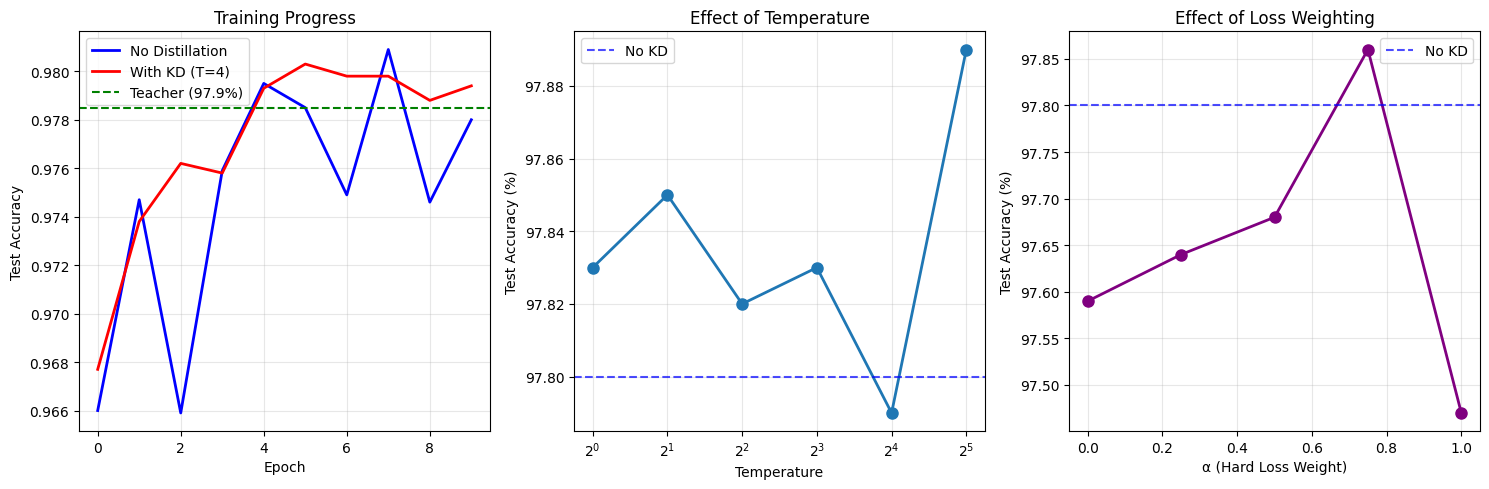

In [21]:
# Visualize response-based distillation results

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Training curves comparison
ax = axes[0]
ax.plot(baseline_history['acc'], 'b-', label='No Distillation', linewidth=2)
ax.plot(kd_history['acc'], 'r-', label='With KD (T=4)', linewidth=2)
ax.axhline(y=teacher_acc, color='green', linestyle='--', label=f'Teacher ({100*teacher_acc:.1f}%)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy')
ax.set_title('Training Progress')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Temperature effect
ax = axes[1]
temps = list(temp_results.keys())
accs = [temp_results[t]['accuracy'] * 100 for t in temps]
ax.plot(temps, accs, 'o-', linewidth=2, markersize=8)
ax.axhline(y=baseline_acc * 100, color='blue', linestyle='--', alpha=0.7, label='No KD')
ax.set_xlabel('Temperature')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Effect of Temperature')
ax.set_xscale('log', base=2)
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Alpha effect
ax = axes[2]
alphs = list(alpha_results.keys())
accs = [alpha_results[a]['accuracy'] * 100 for a in alphs]
ax.plot(alphs, accs, 'o-', linewidth=2, markersize=8, color='purple')
ax.axhline(y=baseline_acc * 100, color='blue', linestyle='--', alpha=0.7, label='No KD')
ax.set_xlabel('α (Hard Loss Weight)')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Effect of Loss Weighting')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('response_distillation.png', dpi=150, bbox_inches='tight')
plt.show()

Feature Based Distillation

In [22]:
def train_student_feature_kd(
    teacher,
    train_loader,
    temperature=4.0,
    alpha=0.5,
    feature_weight=0.1,
    epochs=10
):
    """
    Train student with feature-based distillation (FitNets-style).

    Combines response-based KD with intermediate feature matching.
    """
    print(f"\nTraining student WITH Feature KD (feat_weight={feature_weight})...")

    student = StudentNet().to(device)

    # Feature matching losses for each layer pair
    feat_losses = nn.ModuleList([
        FeatureDistillationLoss(student.feature_dims[i], teacher.feature_dims[i]).to(device)
        for i in range(len(student.feature_dims))
    ])

    # Optimizer includes projector parameters
    all_params = list(student.parameters()) + list(feat_losses.parameters())
    optimizer = torch.optim.Adam(all_params, lr=0.001)
    kd_loss_fn = DistillationLoss(temperature=temperature, alpha=alpha)

    history = {'loss': [], 'acc': [], 'feat_loss': []}

    for epoch in range(epochs):
        student.train()
        total_loss = 0
        total_feat = 0
        correct = 0
        total = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            # Teacher forward (with features)
            with torch.no_grad():
                teacher_logits, teacher_features = teacher(data, return_features=True)

            # Student forward (with features)
            optimizer.zero_grad()
            student_logits, student_features = student(data, return_features=True)

            # Response-based loss
            kd_loss, _ = kd_loss_fn(student_logits, teacher_logits, target)

            # Feature matching loss
            feat_loss = 0
            for i, (s_feat, t_feat) in enumerate(zip(student_features, teacher_features)):
                feat_loss = feat_loss + feat_losses[i](s_feat, t_feat.detach())
            feat_loss = feat_loss / len(student_features)

            # Combined loss
            loss = kd_loss + feature_weight * feat_loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * data.size(0)
            total_feat += feat_loss.item() * data.size(0)
            pred = student_logits.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += data.size(0)

        test_acc = evaluate(student, test_loader)
        history['loss'].append(total_loss / total)
        history['acc'].append(test_acc)
        history['feat_loss'].append(total_feat / total)
        print(f"Epoch {epoch+1}: Test Acc={100*test_acc:.2f}%, Feat Loss={total_feat/total:.4f}")

    return student, history

In [23]:
# Experiment 4: Feature-based distillation

print("\n" + "=" * 70)
print("EXPERIMENT 4: Feature-Based Distillation")
print("=" * 70)

feature_weights = [0.0, 0.01, 0.1, 0.5, 1.0]
feature_results = {}

for fw in feature_weights:
    print(f"\nFeature weight = {fw}")
    student, history = train_student_feature_kd(
        teacher, train_loader,
        temperature=4.0, alpha=0.5,
        feature_weight=fw, epochs=5
    )
    acc = evaluate(student, test_loader)
    feature_results[fw] = {
        'accuracy': acc,
        'history': history
    }
    print(f"Final accuracy: {100*acc:.2f}%")


EXPERIMENT 4: Feature-Based Distillation

Feature weight = 0.0

Training student WITH Feature KD (feat_weight=0.0)...
Epoch 1: Test Acc=96.90%, Feat Loss=0.0017
Epoch 2: Test Acc=97.50%, Feat Loss=0.0017
Epoch 3: Test Acc=97.69%, Feat Loss=0.0017
Epoch 4: Test Acc=97.94%, Feat Loss=0.0017
Epoch 5: Test Acc=97.78%, Feat Loss=0.0017
Final accuracy: 97.78%

Feature weight = 0.01

Training student WITH Feature KD (feat_weight=0.01)...
Epoch 1: Test Acc=96.81%, Feat Loss=0.0007
Epoch 2: Test Acc=97.39%, Feat Loss=0.0004
Epoch 3: Test Acc=97.47%, Feat Loss=0.0003
Epoch 4: Test Acc=97.80%, Feat Loss=0.0003
Epoch 5: Test Acc=97.76%, Feat Loss=0.0003
Final accuracy: 97.76%

Feature weight = 0.1

Training student WITH Feature KD (feat_weight=0.1)...
Epoch 1: Test Acc=96.87%, Feat Loss=0.0005
Epoch 2: Test Acc=97.57%, Feat Loss=0.0003
Epoch 3: Test Acc=97.64%, Feat Loss=0.0002
Epoch 4: Test Acc=97.90%, Feat Loss=0.0002
Epoch 5: Test Acc=97.86%, Feat Loss=0.0002
Final accuracy: 97.86%

Feature we

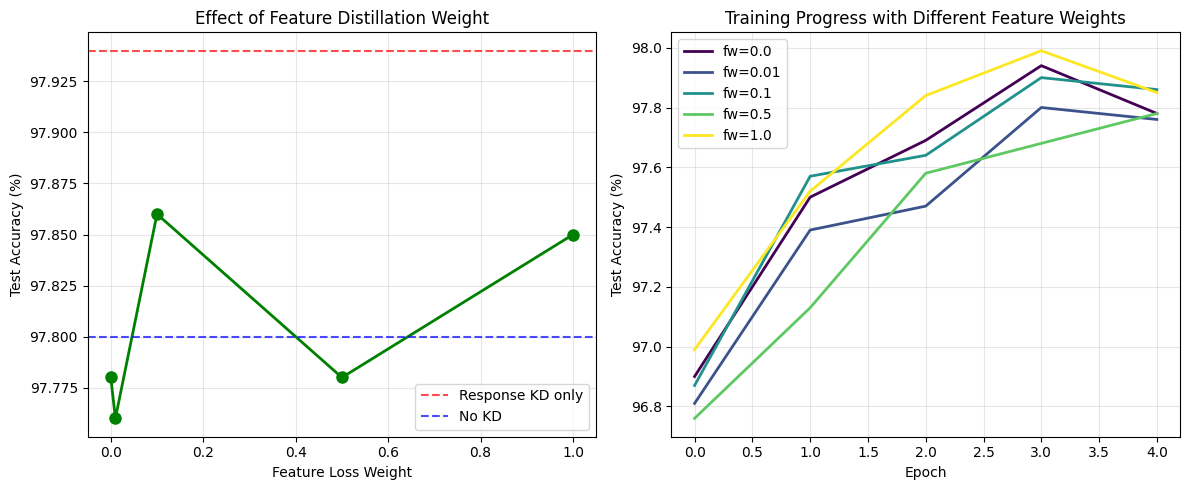

In [24]:
# Visualize feature distillation results

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Feature weight effect
ax = axes[0]
fws = list(feature_results.keys())
accs = [feature_results[fw]['accuracy'] * 100 for fw in fws]
ax.plot(fws, accs, 'o-', linewidth=2, markersize=8, color='green')
ax.axhline(y=kd_acc * 100, color='red', linestyle='--', alpha=0.7, label='Response KD only')
ax.axhline(y=baseline_acc * 100, color='blue', linestyle='--', alpha=0.7, label='No KD')
ax.set_xlabel('Feature Loss Weight')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Effect of Feature Distillation Weight')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Training curves for different feature weights
ax = axes[1]
colors = plt.cm.viridis(np.linspace(0, 1, len(feature_results)))
for (fw, result), color in zip(feature_results.items(), colors):
    ax.plot([a*100 for a in result['history']['acc']],
            label=f'fw={fw}', color=color, linewidth=2)

ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Training Progress with Different Feature Weights')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('feature_distillation.png', dpi=150, bbox_inches='tight')
plt.show()

Relation Based Distillation

In [25]:
def train_student_relation_kd(
    teacher,
    train_loader,
    temperature=4.0,
    alpha=0.5,
    relation_weight=1.0,
    epochs=10
):
    """
    Train student with relation-based distillation (RKD).

    Preserves distance and angle relationships between samples.
    """
    print(f"\nTraining student WITH Relation KD (rel_weight={relation_weight})...")

    student = StudentNet().to(device)
    optimizer = torch.optim.Adam(student.parameters(), lr=0.001)

    kd_loss_fn = DistillationLoss(temperature=temperature, alpha=alpha)
    relation_loss_fn = RelationDistillationLoss(distance_weight=1.0, angle_weight=2.0)

    history = {'loss': [], 'acc': [], 'relation_loss': []}

    for epoch in range(epochs):
        student.train()
        total_loss = 0
        total_rel = 0
        correct = 0
        total = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            # Teacher forward
            with torch.no_grad():
                teacher_logits, teacher_features = teacher(data, return_features=True)
                # Use last hidden layer for relations
                teacher_repr = teacher_features[-1]

            # Student forward
            optimizer.zero_grad()
            student_logits, student_features = student(data, return_features=True)
            student_repr = student_features[-1]

            # Response-based loss
            kd_loss, _ = kd_loss_fn(student_logits, teacher_logits, target)

            # Relation-based loss
            rel_loss, rel_dict = relation_loss_fn(student_repr, teacher_repr.detach())

            # Combined loss
            loss = kd_loss + relation_weight * rel_loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * data.size(0)
            total_rel += rel_loss.item() * data.size(0)
            pred = student_logits.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += data.size(0)

        test_acc = evaluate(student, test_loader)
        history['loss'].append(total_loss / total)
        history['acc'].append(test_acc)
        history['relation_loss'].append(total_rel / total)
        print(f"Epoch {epoch+1}: Test Acc={100*test_acc:.2f}%, Rel Loss={total_rel/total:.4f}")

    return student, history

In [26]:
# Experiment 5: Relation-based distillation

print("\n" + "=" * 70)
print("EXPERIMENT 5: Relation-Based Distillation")
print("=" * 70)

relation_weights = [0.0, 0.1, 0.5, 1.0, 2.0]
relation_results = {}

for rw in relation_weights:
    print(f"\nRelation weight = {rw}")
    student, history = train_student_relation_kd(
        teacher, train_loader,
        temperature=4.0, alpha=0.5,
        relation_weight=rw, epochs=5
    )
    acc = evaluate(student, test_loader)
    relation_results[rw] = {
        'accuracy': acc,
        'history': history
    }
    print(f"Final accuracy: {100*acc:.2f}%")


EXPERIMENT 5: Relation-Based Distillation

Relation weight = 0.0

Training student WITH Relation KD (rel_weight=0.0)...
Epoch 1: Test Acc=96.61%, Rel Loss=0.2736
Epoch 2: Test Acc=97.53%, Rel Loss=0.2100
Epoch 3: Test Acc=97.74%, Rel Loss=0.1899
Epoch 4: Test Acc=97.74%, Rel Loss=0.1736
Epoch 5: Test Acc=97.91%, Rel Loss=0.1596
Final accuracy: 97.91%

Relation weight = 0.1

Training student WITH Relation KD (rel_weight=0.1)...
Epoch 1: Test Acc=96.84%, Rel Loss=0.1890
Epoch 2: Test Acc=97.41%, Rel Loss=0.0933
Epoch 3: Test Acc=97.64%, Rel Loss=0.0629
Epoch 4: Test Acc=97.79%, Rel Loss=0.0464
Epoch 5: Test Acc=97.80%, Rel Loss=0.0368
Final accuracy: 97.80%

Relation weight = 0.5

Training student WITH Relation KD (rel_weight=0.5)...
Epoch 1: Test Acc=96.68%, Rel Loss=0.1097
Epoch 2: Test Acc=97.24%, Rel Loss=0.0325
Epoch 3: Test Acc=97.82%, Rel Loss=0.0201
Epoch 4: Test Acc=97.77%, Rel Loss=0.0146
Epoch 5: Test Acc=97.85%, Rel Loss=0.0118
Final accuracy: 97.85%

Relation weight = 1.0



In [27]:
# Experiment 6: Combined distillation

print("\n" + "=" * 70)
print("EXPERIMENT 6: Combined Distillation (All Methods)")
print("=" * 70)

def train_student_combined_kd(
    teacher,
    train_loader,
    temperature=4.0,
    alpha=0.5,
    feature_weight=0.1,
    relation_weight=0.5,
    epochs=10
):
    """
    Train student with all distillation methods combined.
    """
    print(f"\nTraining with COMBINED KD...")

    student = StudentNet().to(device)

    # Feature matching losses
    feat_losses = nn.ModuleList([
        FeatureDistillationLoss(student.feature_dims[i], teacher.feature_dims[i]).to(device)
        for i in range(len(student.feature_dims))
    ])

    all_params = list(student.parameters()) + list(feat_losses.parameters())
    optimizer = torch.optim.Adam(all_params, lr=0.001)

    kd_loss_fn = DistillationLoss(temperature=temperature, alpha=alpha)
    relation_loss_fn = RelationDistillationLoss()

    history = {'loss': [], 'acc': []}

    for epoch in range(epochs):
        student.train()
        total_loss = 0
        correct = 0
        total = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            with torch.no_grad():
                teacher_logits, teacher_features = teacher(data, return_features=True)

            optimizer.zero_grad()
            student_logits, student_features = student(data, return_features=True)

            # Response loss
            kd_loss, _ = kd_loss_fn(student_logits, teacher_logits, target)

            # Feature loss
            feat_loss = 0
            for i, (s_feat, t_feat) in enumerate(zip(student_features, teacher_features)):
                feat_loss = feat_loss + feat_losses[i](s_feat, t_feat.detach())
            feat_loss = feat_loss / len(student_features)

            # Relation loss
            rel_loss, _ = relation_loss_fn(student_features[-1], teacher_features[-1].detach())

            # Combined
            loss = kd_loss + feature_weight * feat_loss + relation_weight * rel_loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * data.size(0)
            pred = student_logits.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += data.size(0)

        test_acc = evaluate(student, test_loader)
        history['loss'].append(total_loss / total)
        history['acc'].append(test_acc)
        print(f"Epoch {epoch+1}: Test Acc={100*test_acc:.2f}%")

    return student, history


student_combined, combined_history = train_student_combined_kd(
    teacher, train_loader, epochs=10
)
combined_acc = evaluate(student_combined, test_loader)


EXPERIMENT 6: Combined Distillation (All Methods)

Training with COMBINED KD...
Epoch 1: Test Acc=96.86%
Epoch 2: Test Acc=97.43%
Epoch 3: Test Acc=97.83%
Epoch 4: Test Acc=97.71%
Epoch 5: Test Acc=97.92%
Epoch 6: Test Acc=97.85%
Epoch 7: Test Acc=97.90%
Epoch 8: Test Acc=97.78%
Epoch 9: Test Acc=97.99%
Epoch 10: Test Acc=97.92%


In [28]:
# Comprehensive comparison

print("\n" + "=" * 70)
print("COMPREHENSIVE COMPARISON")
print("=" * 70)

# Find best from each category
best_temp = max(temp_results.keys(), key=lambda t: temp_results[t]['accuracy'])
best_feat = max(feature_results.keys(), key=lambda f: feature_results[f]['accuracy'])
best_rel = max(relation_results.keys(), key=lambda r: relation_results[r]['accuracy'])

print(f"\n{'Method':<35} {'Accuracy':<12} {'vs Baseline'}")
print("-" * 60)
print(f"{'Teacher':<35} {100*teacher_acc:.2f}%       —")
print(f"{'Student (no distillation)':<35} {100*baseline_acc:.2f}%       —")
print(f"{'Response KD (T=4)':<35} {100*kd_acc:.2f}%       +{100*(kd_acc-baseline_acc):.2f}%")
print(f"{'Best Temperature (T={best_temp})':<35} {100*temp_results[best_temp]['accuracy']:.2f}%       +{100*(temp_results[best_temp]['accuracy']-baseline_acc):.2f}%")
print(f"{'Feature KD (best)':<35} {100*feature_results[best_feat]['accuracy']:.2f}%       +{100*(feature_results[best_feat]['accuracy']-baseline_acc):.2f}%")
print(f"{'Relation KD (best)':<35} {100*relation_results[best_rel]['accuracy']:.2f}%       +{100*(relation_results[best_rel]['accuracy']-baseline_acc):.2f}%")
print(f"{'Combined KD':<35} {100*combined_acc:.2f}%       +{100*(combined_acc-baseline_acc):.2f}%")


COMPREHENSIVE COMPARISON

Method                              Accuracy     vs Baseline
------------------------------------------------------------
Teacher                             97.85%       —
Student (no distillation)           97.80%       —
Response KD (T=4)                   97.94%       +0.14%
Best Temperature (T={best_temp})    97.89%       +0.09%
Feature KD (best)                   97.86%       +0.06%
Relation KD (best)                  98.01%       +0.21%
Combined KD                         97.92%       +0.12%


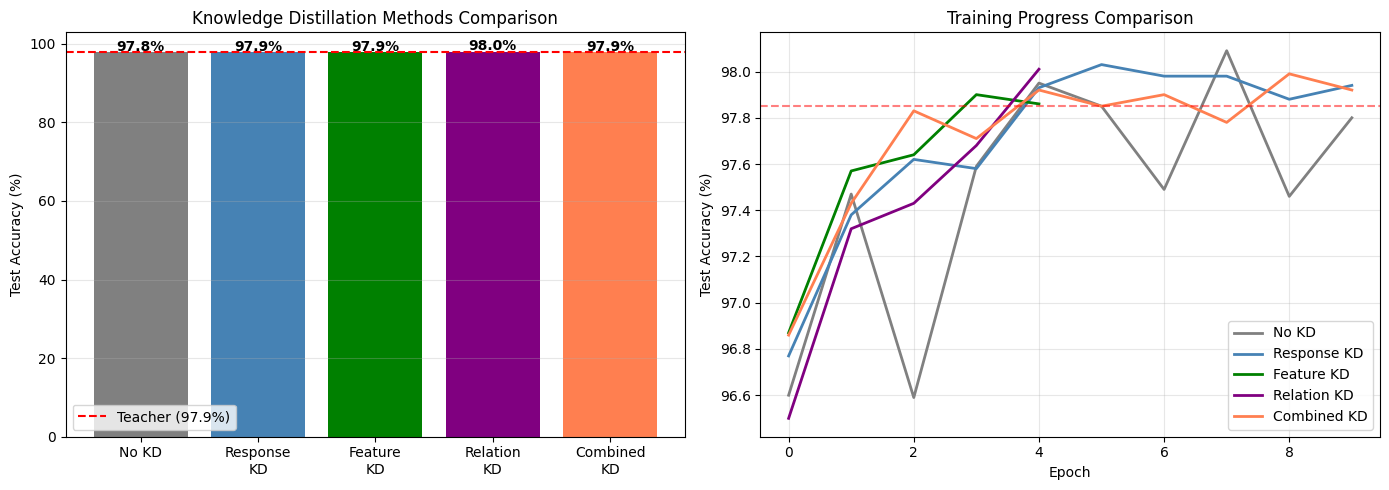

In [29]:
# Final visualization

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Method comparison
ax = axes[0]
methods = ['No KD', 'Response\nKD', 'Feature\nKD', 'Relation\nKD', 'Combined\nKD']
accuracies = [
    baseline_acc * 100,
    kd_acc * 100,
    feature_results[best_feat]['accuracy'] * 100,
    relation_results[best_rel]['accuracy'] * 100,
    combined_acc * 100
]
colors = ['gray', 'steelblue', 'green', 'purple', 'coral']

bars = ax.bar(methods, accuracies, color=colors)
ax.axhline(y=teacher_acc * 100, color='red', linestyle='--', label=f'Teacher ({100*teacher_acc:.1f}%)')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Knowledge Distillation Methods Comparison')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
            f'{acc:.1f}%', ha='center', fontsize=10, fontweight='bold')

# Plot 2: Training curves
ax = axes[1]
ax.plot([a*100 for a in baseline_history['acc']], label='No KD', color='gray', linewidth=2)
ax.plot([a*100 for a in kd_history['acc']], label='Response KD', color='steelblue', linewidth=2)
ax.plot([a*100 for a in feature_results[best_feat]['history']['acc']], label='Feature KD', color='green', linewidth=2)
ax.plot([a*100 for a in relation_results[best_rel]['history']['acc']], label='Relation KD', color='purple', linewidth=2)
ax.plot([a*100 for a in combined_history['acc']], label='Combined KD', color='coral', linewidth=2)
ax.axhline(y=teacher_acc * 100, color='red', linestyle='--', alpha=0.5)

ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Training Progress Comparison')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('kd_comprehensive.png', dpi=150, bbox_inches='tight')
plt.show()